- 라이브러리 불러오기

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import xgboost
import lightgbm
import warnings
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

- 데이터 확인

In [76]:
df = pd.read_csv(r'/content/drive/MyDrive/Kamp/경진대회용 주조 공정최적화 데이터셋.csv', encoding='euc-kr')
df = df.drop('Unnamed: 0',axis=1)
df.head()

,line,name,mold_name,time,date,count,working,emergency_stop,molten_temp,facility_operation_cycleTime,...,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,registration_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:06,258,가동,ON,731.0,119,...,1449.0,550.0,700.0,34.0,23,2019-01-02 16:45:06,0.0,NaN,8722,NaN
1,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:08,243,가동,ON,720.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:08,0.0,NaN,8412,B
2,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:45:58,244,가동,ON,721.0,98,...,NaN,481.0,0.0,30.0,25,2019-01-02 16:45:58,0.0,NaN,8412,B
3,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:48:03,245,가동,ON,721.0,100,...,NaN,483.0,0.0,30.0,25,2019-01-02 16:48:03,0.0,NaN,8412,B
4,전자교반 3라인 2호기,TM Carrier RH,TM Carrier RH-Semi-Solid DIE-06,2019-01-02,16:50:08,246,가동,ON,721.0,99,...,NaN,486.0,0.0,30.0,25,2019-01-02 16:50:08,0.0,NaN,8412,B


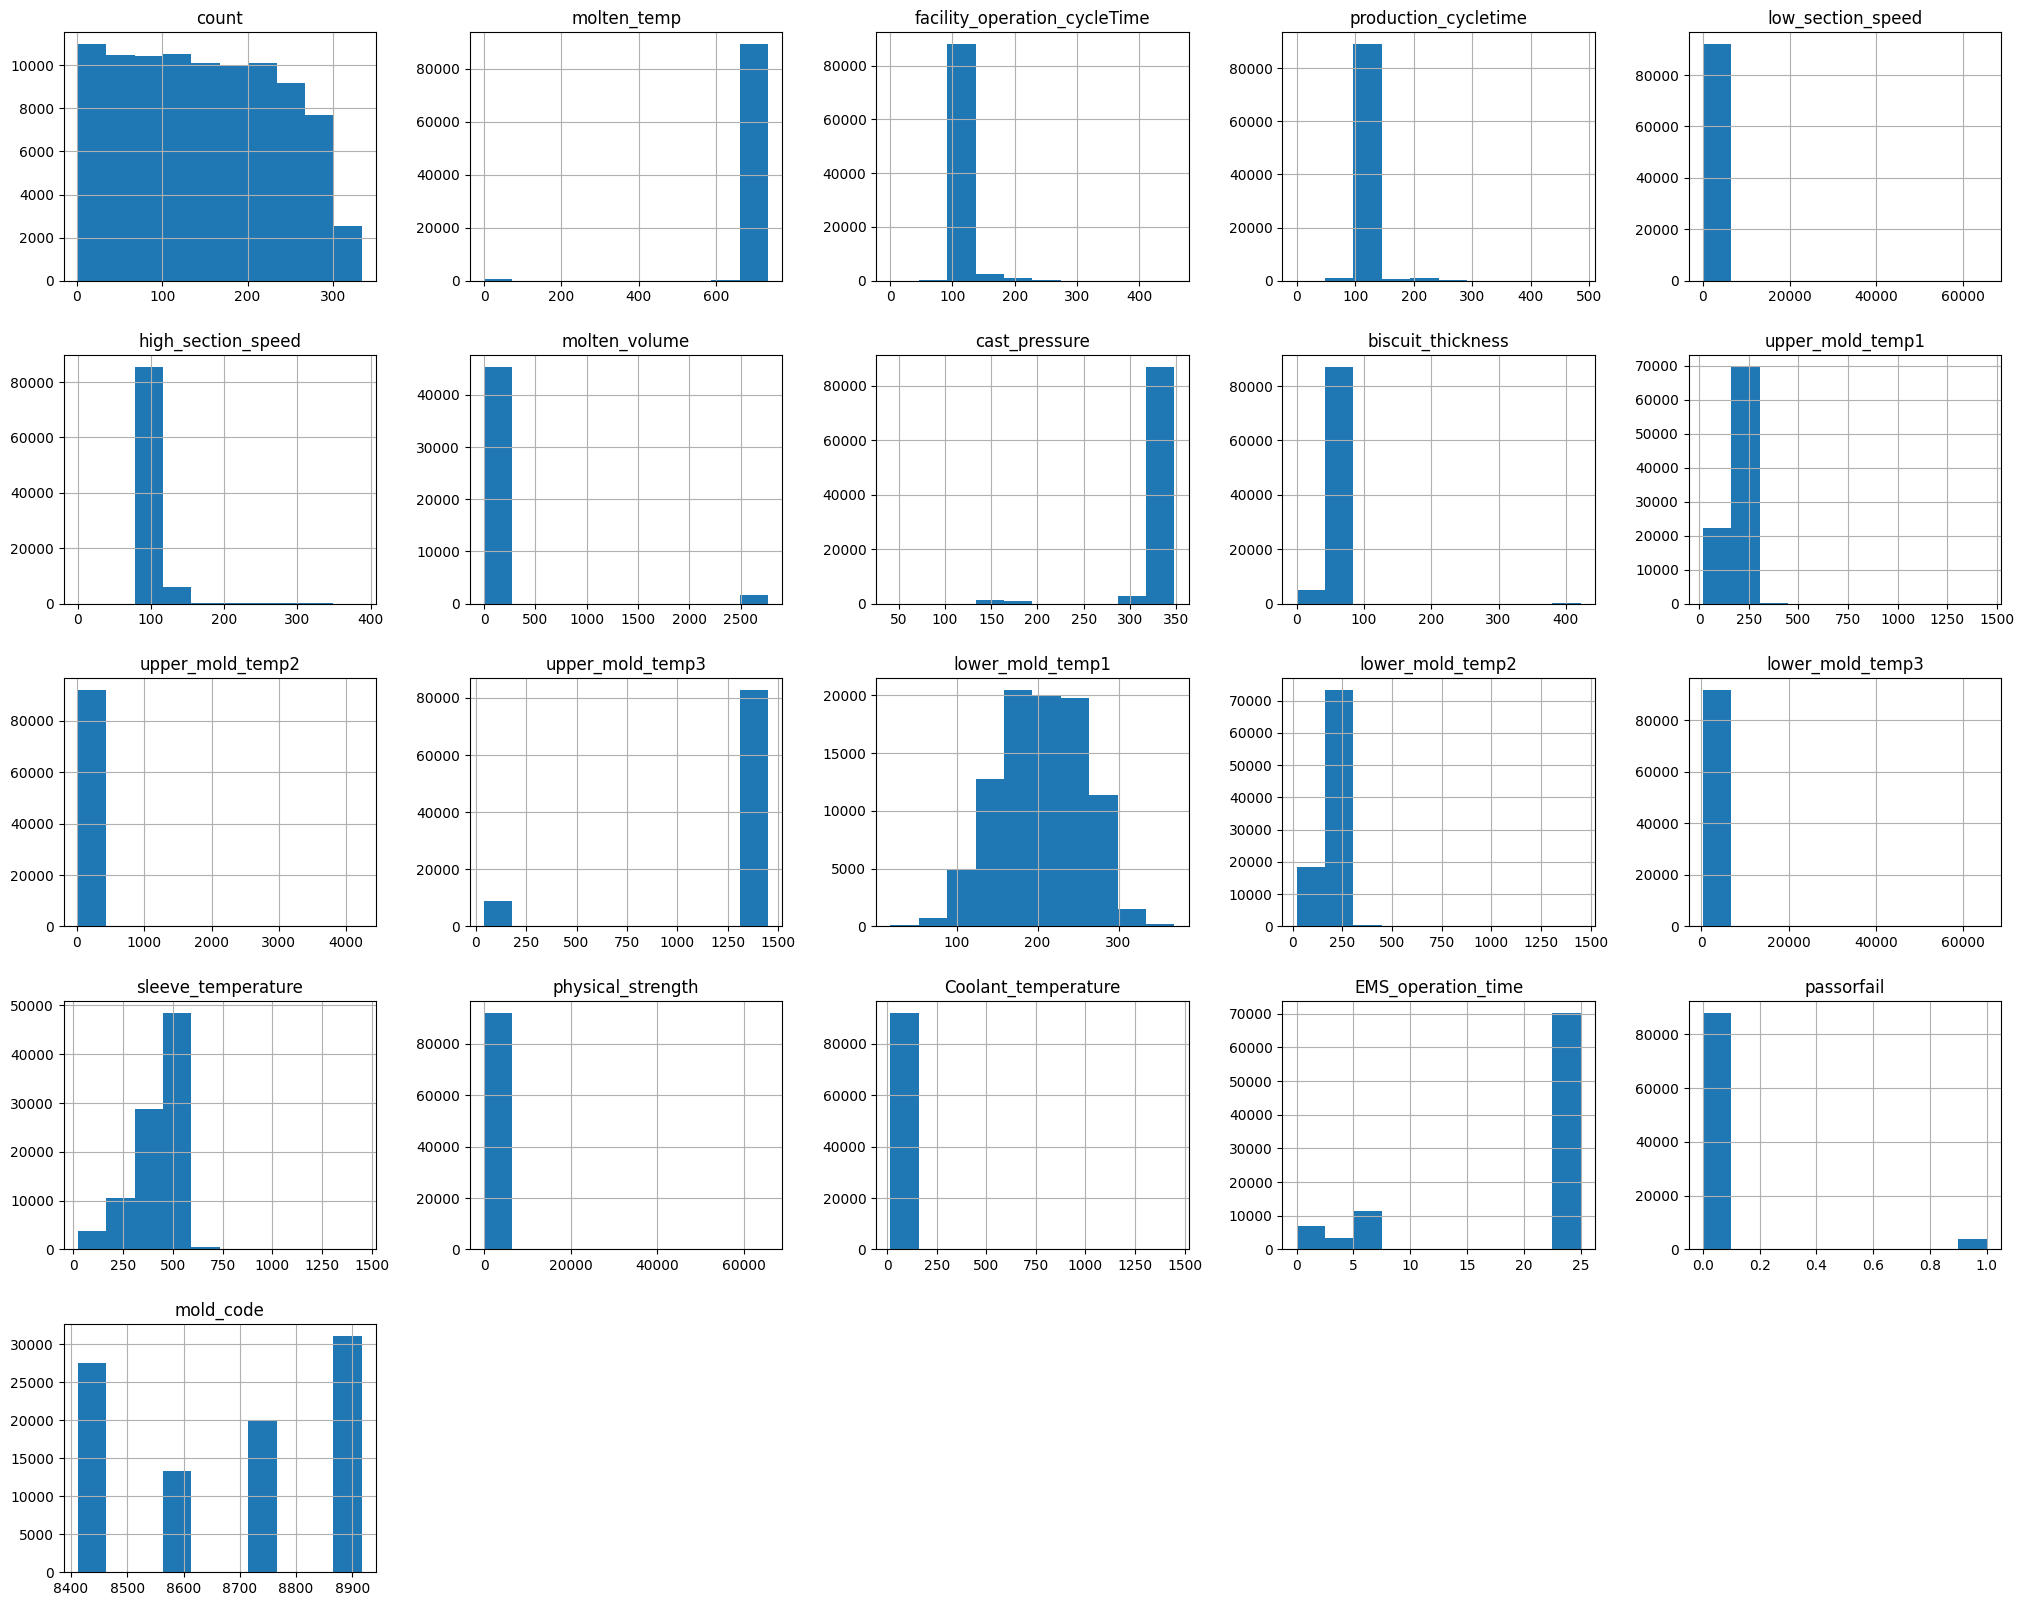

In [4]:
# 히스토그램 데이터 분포 확인
df.hist(figsize=(25,20))
plt.show()

In [5]:
num_pass = len(df[df['passorfail']==0])
num_fail = len(df[df['passorfail']==1])

print(f'pass : {num_pass}')
print(f'fail : {num_fail}')
print(f'불량률 : {num_fail/(num_pass+num_fail)*100} %')

pass : 87998
fail : 4016
불량률 : 4.364553220162149 %


In [6]:
df.columns, len(df.columns)

(Index(['line', 'name', 'mold_name', 'time', 'date', 'count', 'working',
        'emergency_stop', 'molten_temp', 'facility_operation_cycleTime',
        'production_cycletime', 'low_section_speed', 'high_section_speed',
        'molten_volume', 'cast_pressure', 'biscuit_thickness',
        'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3',
        'lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3',
        'sleeve_temperature', 'physical_strength', 'Coolant_temperature',
        'EMS_operation_time', 'registration_time', 'passorfail',
        'tryshot_signal', 'mold_code', 'heating_furnace'],
       dtype='object'),
 31)

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

![image.png](attachment:image.png)

<Axes: >

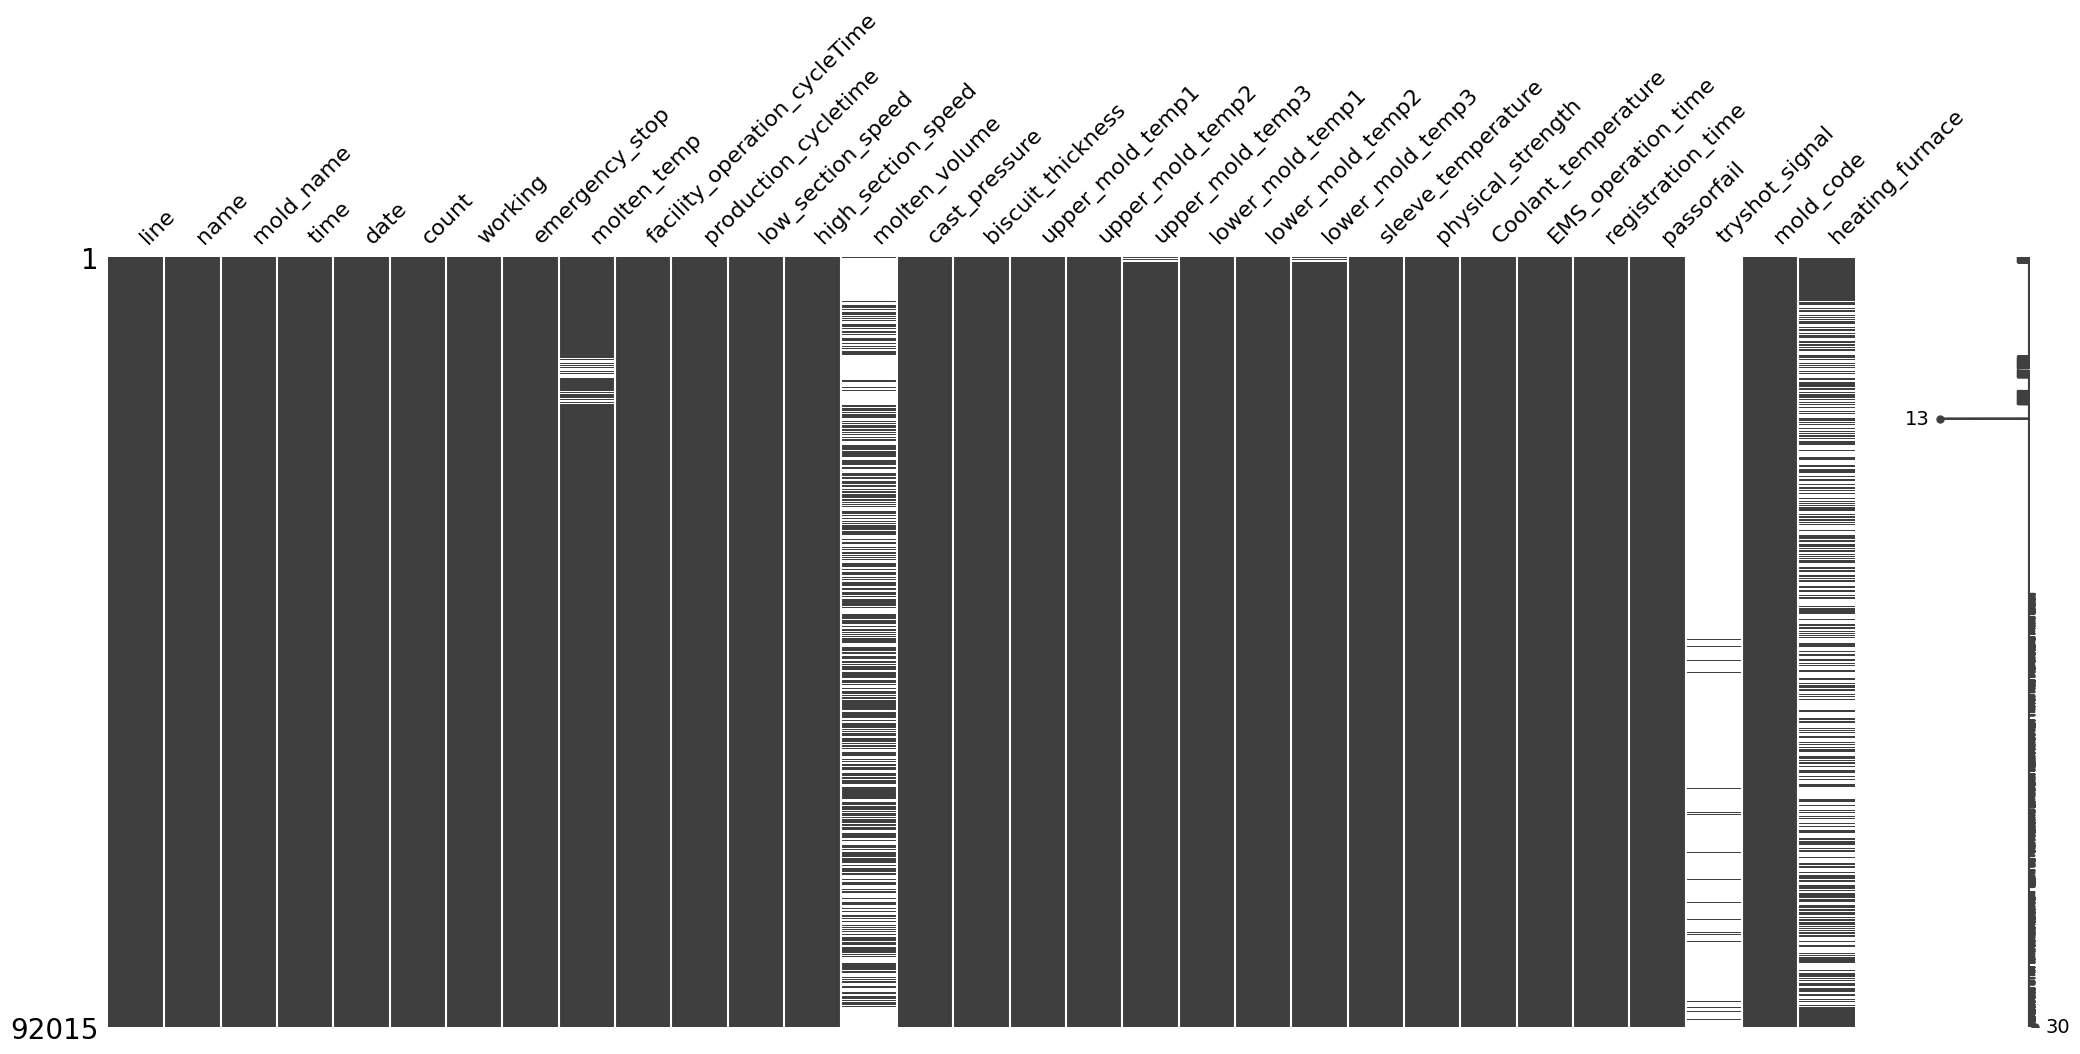

In [7]:
msno.matrix(df)

In [77]:
# 필요없는 컬럼 제거
df = df.drop(columns=['line'])
df = df.drop(columns=['name'])
df = df.drop(columns=['mold_name'])
df = df.drop(columns=['time'])
df = df.drop(columns=['date'])
df = df.drop(columns=['emergency_stop'])
df = df.drop(columns=['molten_volume'])
df = df.drop(columns=['registration_time'])
df = df.dropna(subset=['passorfail'])


# 결측치 채우기
df['tryshot_signal'] = df['tryshot_signal'].fillna('No')   # 과적합으로 인해 컬럼제거 고려 필요
df['heating_furnace'] = df['heating_furnace'].fillna('C')

# 카테고리별 최빈값으로 결측치를 채우기
df['upper_mold_temp3'] = df.groupby('mold_code')['upper_mold_temp3'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))
df['lower_mold_temp3'] = df.groupby('mold_code')['lower_mold_temp3'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))
df['molten_temp'] = df.groupby('mold_code')['molten_temp'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))

df = df.reset_index(drop=True)
df


,count,working,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,...,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,tryshot_signal,mold_code,heating_furnace
0,258,가동,731.0,119,120,110.0,112.0,331.0,35.0,198.0,...,316.0,1449.0,550.0,700.0,34.0,23,0.0,No,8722,C
1,243,가동,720.0,98,125,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,No,8412,B
2,244,가동,721.0,98,122,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,No,8412,B
3,245,가동,721.0,100,125,112.0,109.0,308.0,49.0,268.0,...,179.0,1449.0,483.0,0.0,30.0,25,0.0,No,8412,B
4,246,가동,721.0,99,123,109.0,110.0,309.0,49.0,276.0,...,187.0,1449.0,486.0,0.0,30.0,25,0.0,No,8412,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92009,71,가동,731.0,122,122,100.0,101.0,331.0,49.0,83.0,...,201.0,1449.0,279.0,726.0,30.0,0,0.0,No,8917,A
92010,72,가동,731.0,120,121,100.0,101.0,331.0,54.0,83.0,...,201.0,1449.0,279.0,732.0,30.0,0,0.0,No,8917,A
92011,73,가동,732.0,122,135,100.0,101.0,331.0,52.0,79.0,...,195.0,1449.0,272.0,731.0,30.0,0,0.0,No,8917,A
92012,74,가동,732.0,133,122,100.0,101.0,331.0,53.0,82.0,...,199.0,1449.0,288.0,723.0,30.0,0,0.0,No,8917,A


<Axes: >

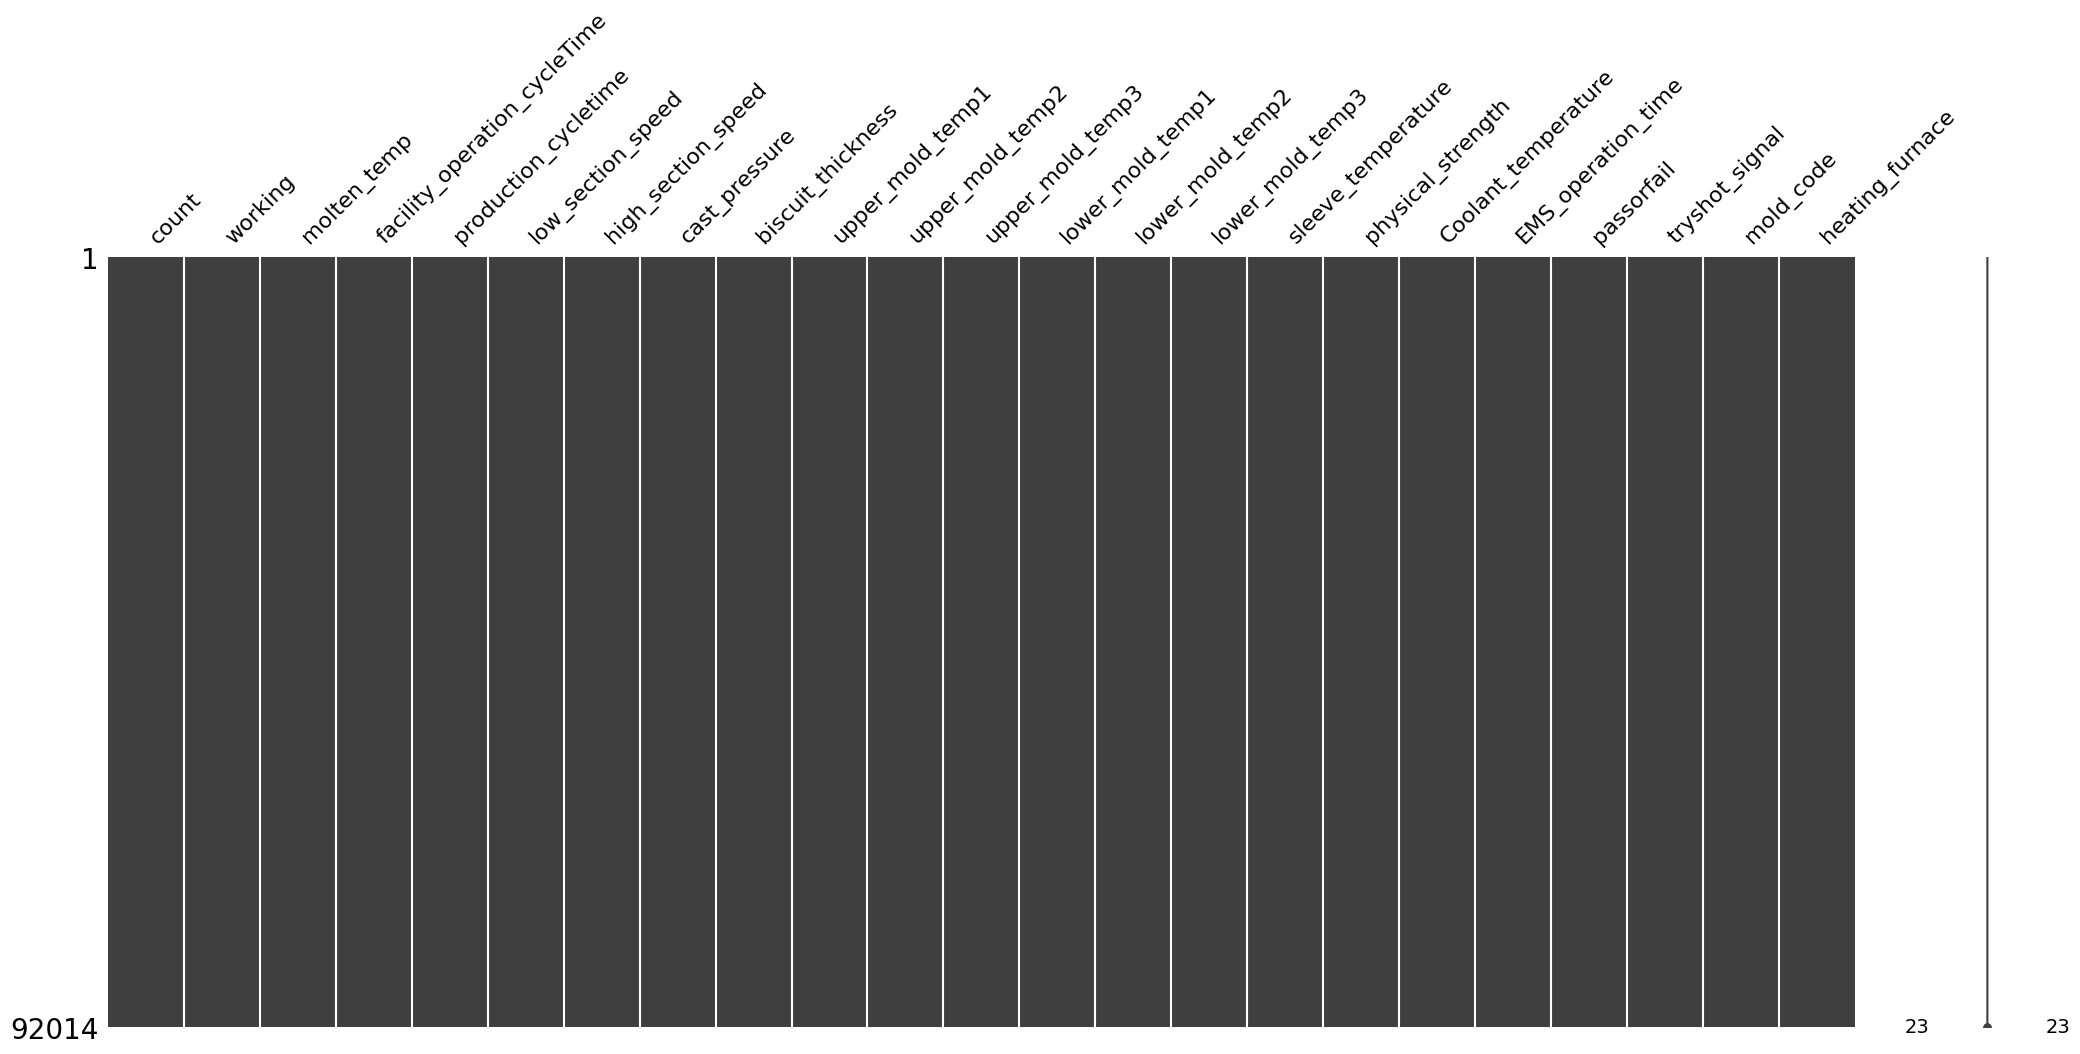

In [72]:
msno.matrix(df)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92014 entries, 0 to 92013
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   count                         92014 non-null  int64  
 1   working                       92014 non-null  object 
 2   molten_temp                   92014 non-null  float64
 3   facility_operation_cycleTime  92014 non-null  int64  
 4   production_cycletime          92014 non-null  int64  
 5   low_section_speed             92014 non-null  float64
 6   high_section_speed            92014 non-null  float64
 7   cast_pressure                 92014 non-null  float64
 8   biscuit_thickness             92014 non-null  float64
 9   upper_mold_temp1              92014 non-null  float64
 10  upper_mold_temp2              92014 non-null  float64
 11  upper_mold_temp3              92014 non-null  float64
 12  lower_mold_temp1              92014 non-null  float64
 13  l

In [79]:
# 인코딩 진행

# 'working' 컬럼 인코딩
df['working'] = df['working'].replace({'가동': 1, '정지': 0})

# 'tryshot_signal' 컬럼 인코딩
df['tryshot_signal'] = df['tryshot_signal'].replace({'D': 1, 'No': 0})

# 'heating_furnace' 컬럼 인코딩
df['heating_furnace'] = df['heating_furnace'].replace({'A': 0, 'B': 1, 'C': 2})


In [81]:
# 통계량 확인
df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,92014.0,148.509455,87.969347,1.0,72.0,146.0,222.0,334.0
working,92014.0,0.999446,0.023536,0.0,1.0,1.0,1.0,1.0
molten_temp,92014.0,718.922718,51.125384,0.0,713.0,728.0,731.0,735.0
facility_operation_cycleTime,92014.0,121.556328,12.109582,69.0,117.0,119.0,122.0,457.0
production_cycletime,92014.0,122.515856,13.589387,0.0,119.0,121.0,123.0,485.0
low_section_speed,92014.0,110.794999,305.181962,0.0,110.0,110.0,110.0,65535.0
high_section_speed,92014.0,112.624959,10.759272,0.0,112.0,112.0,112.0,388.0
cast_pressure,92014.0,324.554535,27.327683,41.0,329.0,330.0,331.0,348.0
biscuit_thickness,92014.0,50.666486,17.925620,0.0,47.0,50.0,53.0,422.0
upper_mold_temp1,92014.0,186.208870,46.041322,18.0,163.0,194.0,222.0,1449.0


- 이상치 제거
    - 상하한 0.1%에 대한 이상치 제거함
    - IQR 적용시 불량 데이터가 너무 많이 제거됨

In [82]:
num_df = df

In [83]:
for col in num_df.columns:
 UCL = np.percentile(num_df[col], 99.9)
 LCL = np.percentile(num_df[col], 0.1)
 num_df = num_df[(num_df[col] <= UCL) & (num_df[col] >= LCL)]
num_df.reset_index()
num_df

,count,working,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,...,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,tryshot_signal,mold_code,heating_furnace
1,243,1,720.0,98,125,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,0,8412,1
2,244,1,721.0,98,122,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,0,8412,1
3,245,1,721.0,100,125,112.0,109.0,308.0,49.0,268.0,...,179.0,1449.0,483.0,0.0,30.0,25,0.0,0,8412,1
4,246,1,721.0,99,123,109.0,110.0,309.0,49.0,276.0,...,187.0,1449.0,486.0,0.0,30.0,25,0.0,0,8412,1
5,247,1,722.0,100,125,110.0,110.0,308.0,50.0,279.0,...,195.0,1449.0,485.0,0.0,30.0,25,0.0,0,8412,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92009,71,1,731.0,122,122,100.0,101.0,331.0,49.0,83.0,...,201.0,1449.0,279.0,726.0,30.0,0,0.0,0,8917,0
92010,72,1,731.0,120,121,100.0,101.0,331.0,54.0,83.0,...,201.0,1449.0,279.0,732.0,30.0,0,0.0,0,8917,0
92011,73,1,732.0,122,135,100.0,101.0,331.0,52.0,79.0,...,195.0,1449.0,272.0,731.0,30.0,0,0.0,0,8917,0
92012,74,1,732.0,133,122,100.0,101.0,331.0,53.0,82.0,...,199.0,1449.0,288.0,723.0,30.0,0,0.0,0,8917,0


In [84]:
# 통계량 확인
num_df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,89821.0,149.252614,87.532036,1.0,73.0,147.0,223.0,324.0
working,89821.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
molten_temp,89821.0,718.942797,50.822230,0.0,713.0,728.0,731.0,734.0
facility_operation_cycleTime,89821.0,121.455383,11.318764,77.0,117.0,119.0,122.0,229.0
production_cycletime,89821.0,122.435589,12.225053,78.0,119.0,121.0,123.0,244.0
low_section_speed,89821.0,109.600839,8.712919,0.0,110.0,110.0,110.0,140.0
high_section_speed,89821.0,112.419635,8.662189,101.0,112.0,112.0,112.0,245.0
cast_pressure,89821.0,325.651173,23.777324,144.0,329.0,330.0,331.0,338.0
biscuit_thickness,89821.0,50.159918,10.329411,31.0,47.0,50.0,53.0,420.0
upper_mold_temp1,89821.0,186.977032,44.764869,30.0,164.0,194.0,222.0,311.0


- T-test
    - T-test는 양품과 불량데이터간 차이가 유의미한 변수를 확인하는 것
    - 각 변수별로
        - ‘양품 집단과 불량 집단의 평균 차이가 없다’를 귀무가설
        - ‘양품 집단과 불량 집단의 평균 차이가 있다’를 대립가설
    - pvalue 값이 0.05 미만인 경우 귀무가설을 기각하고 대립가설을 채택

In [86]:
t_test = []
for i, col in enumerate(num_df.columns):
 t=scipy.stats.ttest_ind(num_df[num_df['passorfail']==1][col], num_df[num_df['passorfail']==0][col],
equal_var=False)
 t_test.append([col, t[0], t[1]])
df_ttest = pd.DataFrame(t_test, columns=['col', 'tvalue', 'pvalue'])
use_t_list = []
for i in range(len(df_ttest)):
 if df_ttest['pvalue'][i] < 0.05:
    use_t_list.append(df_ttest['col'][i])
df_ttest

,col,tvalue,pvalue
0,count,-45.453181,0.000000e+00
1,working,NaN,NaN
2,molten_temp,3.736849,1.893953e-04
3,facility_operation_cycleTime,1.184108,2.364574e-01
4,production_cycletime,-15.764287,5.968797e-54
5,low_section_speed,-18.169537,3.776236e-70
6,high_section_speed,6.120036,1.053225e-09
7,cast_pressure,-65.774761,0.000000e+00
8,biscuit_thickness,6.301109,3.379908e-10
9,upper_mold_temp1,-49.873606,0.000000e+00


In [87]:
# facility_operation_cycleTime, upper_mold_temp3 제거
num_df.drop(columns='facility_operation_cycleTime')
num_df.drop(columns='upper_mold_temp3')
num_df

,count,working,molten_temp,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,...,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail,tryshot_signal,mold_code,heating_furnace
1,243,1,720.0,98,125,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,0,8412,1
2,244,1,721.0,98,122,109.0,109.0,309.0,48.0,250.0,...,163.0,1449.0,481.0,0.0,30.0,25,0.0,0,8412,1
3,245,1,721.0,100,125,112.0,109.0,308.0,49.0,268.0,...,179.0,1449.0,483.0,0.0,30.0,25,0.0,0,8412,1
4,246,1,721.0,99,123,109.0,110.0,309.0,49.0,276.0,...,187.0,1449.0,486.0,0.0,30.0,25,0.0,0,8412,1
5,247,1,722.0,100,125,110.0,110.0,308.0,50.0,279.0,...,195.0,1449.0,485.0,0.0,30.0,25,0.0,0,8412,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92009,71,1,731.0,122,122,100.0,101.0,331.0,49.0,83.0,...,201.0,1449.0,279.0,726.0,30.0,0,0.0,0,8917,0
92010,72,1,731.0,120,121,100.0,101.0,331.0,54.0,83.0,...,201.0,1449.0,279.0,732.0,30.0,0,0.0,0,8917,0
92011,73,1,732.0,122,135,100.0,101.0,331.0,52.0,79.0,...,195.0,1449.0,272.0,731.0,30.0,0,0.0,0,8917,0
92012,74,1,732.0,133,122,100.0,101.0,331.0,53.0,82.0,...,199.0,1449.0,288.0,723.0,30.0,0,0.0,0,8917,0


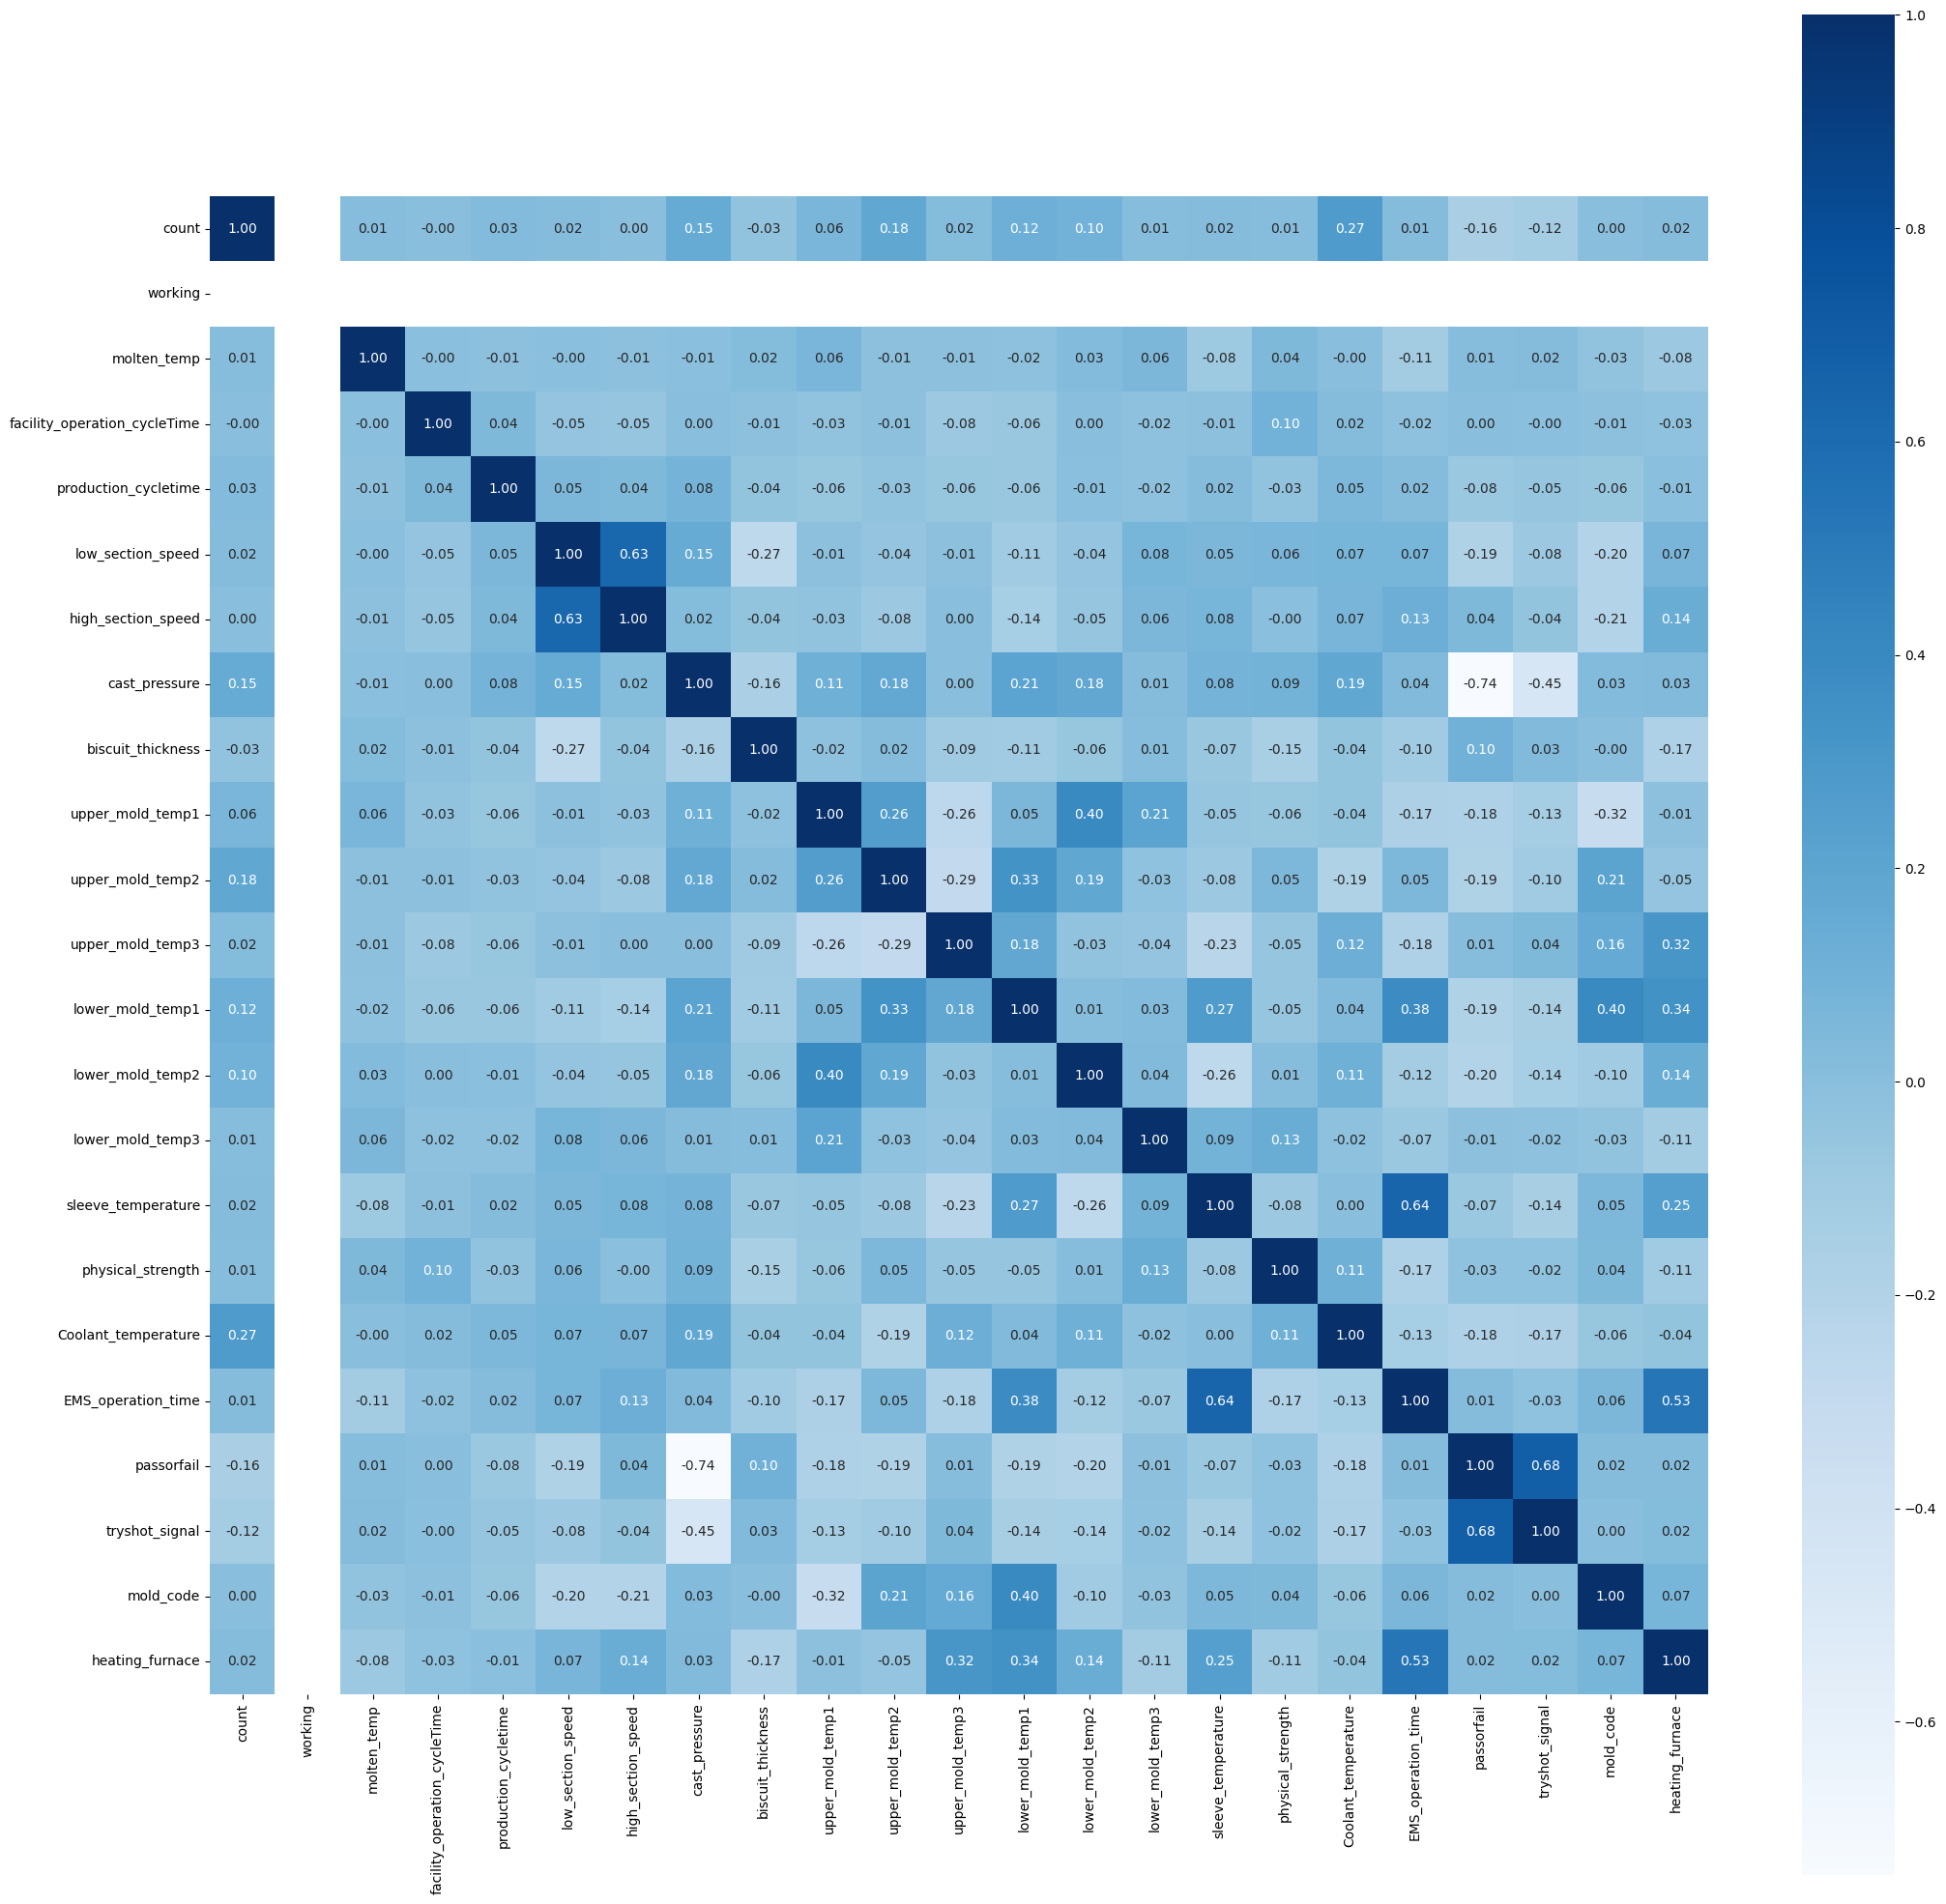

In [90]:
plt.figure(figsize=(25,25))
sns.heatmap(num_df.corr(), annot=True, fmt='.2f', square=True, cmap='Blues')
plt.show()

- passorfail과 cast_pressure의 상관계수는 0.7로 매우 높은 음의 상관관계를 보이며
- high_section_speed와 low_section_speed는 0.6로 높은 양의 상관관계를 보인다.


- 알고리즘 선택

In [91]:
df_done = num_df
X = df_done.drop('passorfail', axis=1).values
y = df_done['passorfail'].values

In [92]:
# 불량률이 3%에 불과한 데이터에 대해 분할 split마다 양품과 불량이 균등한 비율로 구성되도록 StratifiedShuffleSplit을 적용
sss = StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2)

In [93]:
# 0~1사이로 정규화
# 데이터 정규화를 하는 이유는 각 변수별로 값의 범위가 다르게 되면
# 모델은 크기가 큰 변수에 영향을 많이 받게 되어 부정확한 모델이 생성
mms = MinMaxScaler()

In [94]:
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42, eval_metric='error', use_label_encoder=False)
lgbm_clf = LGBMClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

- DecisionTree

In [95]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_fold_f1 = []
n_iter = 0
print('모델 :', dt_clf)
idx_list = []
for train_idx, test_idx in sss.split(X, y):
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    dt_clf.fit(X_train_scaled, y_train)
    valid_pred = dt_clf.predict(X_valid_scaled)
    test_pred = dt_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    valid_CR = classification_report(y_valid, valid_pred)
    test_CR = classification_report(y_test, test_pred)
    n_iter += 1
    dt_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
  print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 report : {valid_CR}')
  print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 report : {test_CR}')
  print('='*50)
  dt_fold_f1.sort(key=lambda x : x[1], reverse=True)
  print(f'교차검증 중 가장 높은 정확도 : Split {dt_fold_f1[0][0]} {dt_fold_f1[0][1]}')

모델 : DecisionTreeClassifier(random_state=42)
StratifiedShuffleSplit 5 검증 데이터 report :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13883
         1.0       1.00      1.00      1.00       489

    accuracy                           1.00     14372
   macro avg       1.00      1.00      1.00     14372
weighted avg       1.00      1.00      1.00     14372

StratifiedShuffleSplit 5 테스트 데이터 report :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17354
         1.0       0.93      0.94      0.93       611

    accuracy                           1.00     17965
   macro avg       0.96      0.97      0.97     17965
weighted avg       1.00      1.00      1.00     17965

교차검증 중 가장 높은 정확도 : Split 1 0.9338775510204081
StratifiedShuffleSplit 10 검증 데이터 report :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13883
         1.0       1.

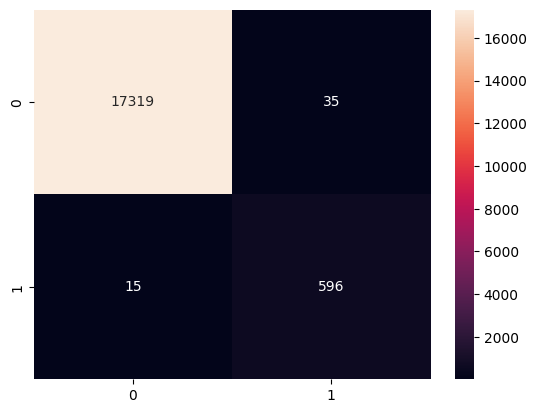

In [96]:
dt_clf.fit(X[idx_list[dt_fold_f1[0][0]-1][0]], y[idx_list[dt_fold_f1[0][0]-1][0]])
pred = dt_clf.predict(X[idx_list[dt_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[dt_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- RandomForest

In [97]:
rf_clf = RandomForestClassifier(random_state=42)
rf_fold_f1 = []
n_iter = 0
print('모델 :', rf_clf)
idx_list = []
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]

 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    rf_clf.fit(X_train_scaled, y_train)
    valid_pred = rf_clf.predict(X_valid_scaled)
    test_pred = rf_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    rf_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 dt_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {rf_fold_f1[0][0]} {rf_fold_f1[0][1]}')

모델 : RandomForestClassifier(random_state=42)
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.9575353871773522
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522
StratifiedShuffleSplit 10 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 10 테스트 데이터 f1 정확도 : 0.9511184755592378
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522
StratifiedShuffleSplit 15 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 15 테스트 데이터 f1 정확도 : 0.949748743718593
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522
StratifiedShuffleSplit 20 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 20 테스트 데이터 f1 정확도 : 0.950544844928751
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522
StratifiedShuffleSplit 25 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 25 테스트 데이터 f1 정확도 : 0.9563758389261745
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522


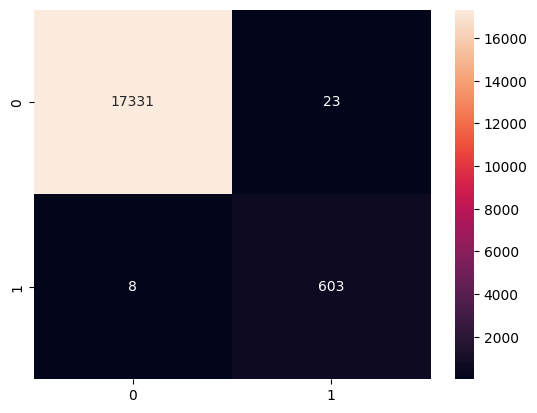

In [98]:
rf_clf.fit(X[idx_list[rf_fold_f1[0][0]-1][0]], y[idx_list[rf_fold_f1[0][0]-1][0]])
pred = rf_clf.predict(X[idx_list[rf_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[rf_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- XGBoost

In [99]:
xgb_clf = RandomForestClassifier(random_state=42)
xgb_fold_f1 = []
n_iter = 0
print('모델 :', xgb_clf)
idx_list = []
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]

 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    xgb_clf.fit(X_train_scaled, y_train)
    valid_pred = xgb_clf.predict(X_valid_scaled)
    test_pred = xgb_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    xgb_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 xgb_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {xgb_fold_f1[0][0]} {xgb_fold_f1[0][1]}')

모델 : RandomForestClassifier(random_state=42)
StratifiedShuffleSplit 5 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 5 테스트 데이터 f1 정확도 : 0.9575353871773522
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522
StratifiedShuffleSplit 10 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 10 테스트 데이터 f1 정확도 : 0.9511184755592378
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522
StratifiedShuffleSplit 15 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 15 테스트 데이터 f1 정확도 : 0.949748743718593
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522
StratifiedShuffleSplit 20 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 20 테스트 데이터 f1 정확도 : 0.950544844928751
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522
StratifiedShuffleSplit 25 검증 데이터 f1 정확도 : 1.0
StratifiedShuffleSplit 25 테스트 데이터 f1 정확도 : 0.9563758389261745
교차검증 중 가장 높은 정확도 : Split 1 0.9575353871773522


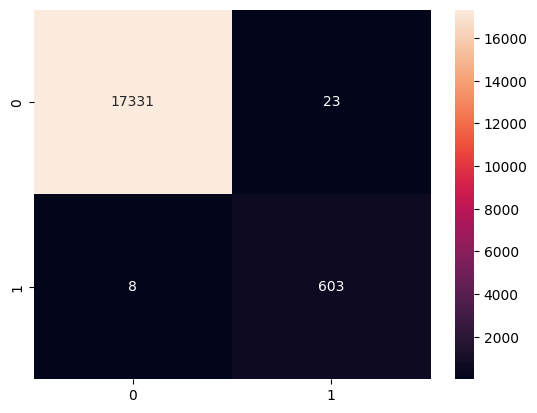

In [100]:
xgb_clf.fit(X[idx_list[xgb_fold_f1[0][0]-1][0]], y[idx_list[xgb_fold_f1[0][0]-1][0]])
pred = xgb_clf.predict(X[idx_list[xgb_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[xgb_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- LightGBM

In [101]:
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_fold_f1 = []
n_iter = 0
print('모델 :', lgbm_clf)
idx_list = []
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]

 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    lgbm_clf.fit(X_train_scaled, y_train)
    valid_pred = lgbm_clf.predict(X_valid_scaled)
    test_pred = lgbm_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    lgbm_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 lgbm_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {lgbm_fold_f1[0][0]} {lgbm_fold_f1[0][1]}')

모델 : LGBMClassifier(random_state=42)
[LightGBM] [Info] Number of positive: 2444, number of negative: 69412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2502
[LightGBM] [Info] Number of data points in the train set: 71856, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034012 -> initscore=-3.346424
[LightGBM] [Info] Start training from score -3.346424
[LightGBM] [Info] Number of positive: 2444, number of negative: 69412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2502
[LightGBM] [Info] Number of data points in the train set: 71856, number of u

[LightGBM] [Info] Number of positive: 1963, number of negative: 55521
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 57484, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034149 -> initscore=-3.342287
[LightGBM] [Info] Start training from score -3.342287


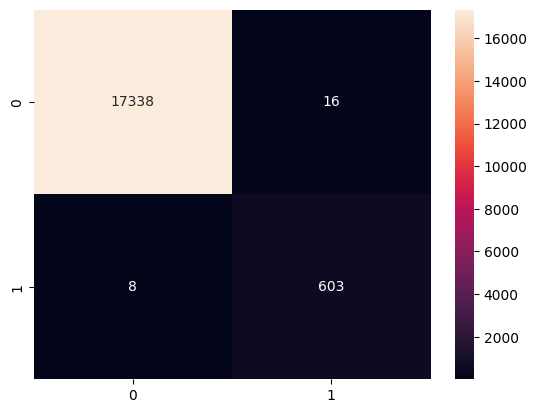

In [102]:
lgbm_clf.fit(X[idx_list[lgbm_fold_f1[0][0]-1][0]], y[idx_list[lgbm_fold_f1[0][0]-1][0]])
pred = lgbm_clf.predict(X[idx_list[lgbm_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[lgbm_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- AdaBoost

In [103]:
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedShuffleSplit

# 예시 데이터 및 스케일러 정의
# X, y = ...  # 데이터 로드 또는 정의
mms = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

ada_clf = AdaBoostClassifier(random_state=42)
ada_fold_f1 = []
n_iter = 0
print('모델 :', ada_clf)
idx_list = []

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for train_idx, valid_idx in sss.split(X_train, y_train):
        X_valid = X_train[valid_idx]
        y_valid = y_train[valid_idx]
        X_train_scaled = mms.fit_transform(X_train)
        X_test_scaled = mms.transform(X_test)
        X_valid_scaled = mms.transform(X_valid)

        ada_clf.fit(X_train_scaled, y_train)
        valid_pred = ada_clf.predict(X_valid_scaled)
        test_pred = ada_clf.predict(X_test_scaled)

        valid_f1 = f1_score(y_valid, valid_pred)
        test_f1 = f1_score(y_test, test_pred)

        n_iter += 1
        ada_fold_f1.append([n_iter, test_f1])
        idx_list.append([train_idx, test_idx])

        # 검증 데이터에 대한 classification_report 출력
        print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
        print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')

        # classification_report 출력
        print(classification_report(y_valid, valid_pred))

        print('='*50)

# F1 점수를 정렬
ada_fold_f1.sort(key=lambda x: x[1], reverse=True)


모델 : AdaBoostClassifier(random_state=42)
StratifiedShuffleSplit 1 검증 데이터 f1 정확도 : 0.9432773109243697
StratifiedShuffleSplit 1 테스트 데이터 f1 정확도 : 0.9200680272108843
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13883
         1.0       0.97      0.92      0.94       489

    accuracy                           1.00     14372
   macro avg       0.98      0.96      0.97     14372
weighted avg       1.00      1.00      1.00     14372

StratifiedShuffleSplit 2 검증 데이터 f1 정확도 : 0.9192680301399354
StratifiedShuffleSplit 2 테스트 데이터 f1 정확도 : 0.9200680272108843
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13883
         1.0       0.97      0.87      0.92       489

    accuracy                           0.99     14372
   macro avg       0.98      0.94      0.96     14372
weighted avg       0.99      0.99      0.99     14372

StratifiedShuffleSplit 3 검증 데이터 f1 정확도 : 0.9263157894736842
Str

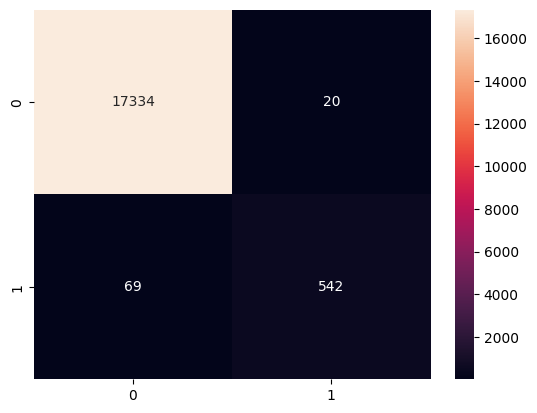

In [104]:
ada_clf.fit(X[idx_list[ada_fold_f1[0][0]-1][0]], y[idx_list[ada_fold_f1[0][0]-1][0]])
pred = ada_clf.predict(X[idx_list[ada_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[ada_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

In [105]:
!pip install catboost

In [106]:
from catboost import CatBoostClassifier
cat_clf = CatBoostClassifier(random_state=42)
cat_fold_f1 = []
n_iter = 0
print('모델 :', cat_clf)
idx_list = []
for train_idx, test_idx in sss.split(X, y):
 X_train, X_test = X[train_idx], X[test_idx]
 y_train, y_test = y[train_idx], y[test_idx]

 for train_idx, valid_idx in sss.split(X_train, y_train):
    X_valid = X_train[valid_idx]
    y_valid = y_train[valid_idx]
    X_train_scaled = mms.fit_transform(X_train)
    X_test_scaled = mms.transform(X_test)
    X_valid_scaled = mms.transform(X_valid)
    cat_clf.fit(X_train_scaled, y_train)
    valid_pred = cat_clf.predict(X_valid_scaled)
    test_pred = cat_clf.predict(X_test_scaled)
    valid_f1 = f1_score(y_valid, valid_pred)
    test_f1 = f1_score(y_test, test_pred)
    n_iter += 1
    cat_fold_f1.append([n_iter, test_f1])
    idx_list.append([train_idx, test_idx])
 print(f'StratifiedShuffleSplit {n_iter} 검증 데이터 f1 정확도 : {valid_f1}')
 print(f'StratifiedShuffleSplit {n_iter} 테스트 데이터 f1 정확도 : {test_f1}')
 print('='*50)
 lgbm_fold_f1.sort(key=lambda x : x[1], reverse=True)
 print(f'교차검증 중 가장 높은 정확도 : Split {cat_fold_f1[0][0]} {cat_fold_f1[0][1]}')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
8:	learn: 0.0960716	total: 161ms	remaining: 17.7s
9:	learn: 0.0810644	total: 178ms	remaining: 17.6s
10:	learn: 0.0715103	total: 195ms	remaining: 17.6s
11:	learn: 0.0633567	total: 220ms	remaining: 18.1s
12:	learn: 0.0565101	total: 237ms	remaining: 18s
13:	learn: 0.0515719	total: 255ms	remaining: 18s
14:	learn: 0.0469855	total: 272ms	remaining: 17.9s
15:	learn: 0.0428307	total: 288ms	remaining: 17.7s
16:	learn: 0.0398581	total: 305ms	remaining: 17.6s
17:	learn: 0.0368492	total: 322ms	remaining: 17.6s
18:	learn: 0.0344262	total: 338ms	remaining: 17.5s
19:	learn: 0.0329522	total: 355ms	remaining: 17.4s
20:	learn: 0.0310699	total: 371ms	remaining: 17.3s
21:	learn: 0.0297237	total: 387ms	remaining: 17.2s
22:	learn: 0.0284565	total: 402ms	remaining: 17.1s
23:	learn: 0.0274371	total: 419ms	remaining: 17s
24:	learn: 0.0265463	total: 442ms	remaining: 17.3s
25:	learn: 0.0255366	total: 460ms	remaining: 17.2s
26:	learn: 0.0249035	total: 477ms	remaining: 17.2s
27:

Learning rate set to 0.058111
0:	learn: 0.5553964	total: 15.2ms	remaining: 15.2s
1:	learn: 0.4537520	total: 26.1ms	remaining: 13s
2:	learn: 0.3693240	total: 40.6ms	remaining: 13.5s
3:	learn: 0.3042311	total: 59.7ms	remaining: 14.9s
4:	learn: 0.2514669	total: 74.3ms	remaining: 14.8s
5:	learn: 0.2074909	total: 88.4ms	remaining: 14.6s
6:	learn: 0.1729551	total: 102ms	remaining: 14.4s
7:	learn: 0.1452286	total: 116ms	remaining: 14.4s
8:	learn: 0.1229246	total: 129ms	remaining: 14.2s
9:	learn: 0.1047535	total: 142ms	remaining: 14s
10:	learn: 0.0925672	total: 155ms	remaining: 13.9s
11:	learn: 0.0811109	total: 168ms	remaining: 13.8s
12:	learn: 0.0721438	total: 184ms	remaining: 13.9s
13:	learn: 0.0654268	total: 203ms	remaining: 14.3s
14:	learn: 0.0590464	total: 217ms	remaining: 14.2s
15:	learn: 0.0541802	total: 231ms	remaining: 14.2s
16:	learn: 0.0493872	total: 244ms	remaining: 14.1s
17:	learn: 0.0457708	total: 257ms	remaining: 14s
18:	learn: 0.0424787	total: 273ms	remaining: 14.1s
19:	learn: 

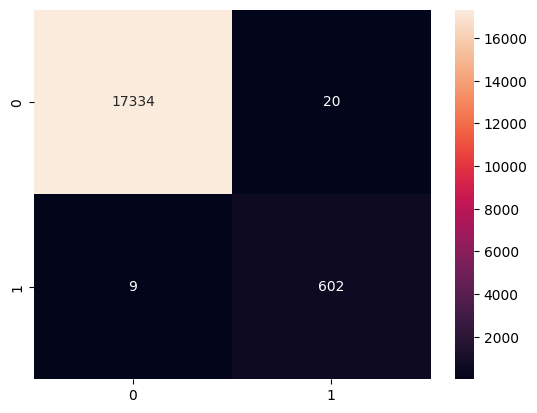

In [107]:
cat_clf.fit(X[idx_list[cat_fold_f1[0][0]-1][0]], y[idx_list[cat_fold_f1[0][0]-1][0]])
pred = cat_clf.predict(X[idx_list[cat_fold_f1[0][0]-1][1]])
cm = confusion_matrix(y[idx_list[cat_fold_f1[0][0]-1][1]], pred)
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()

- LightGBM Permutation Imoprtance

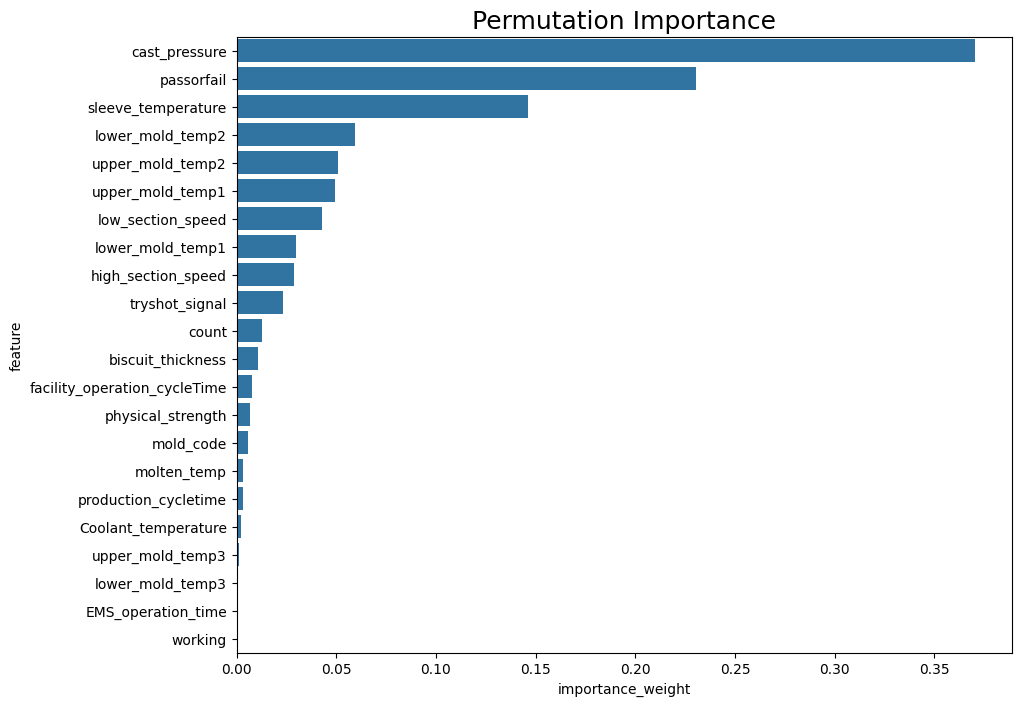

In [108]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(
    estimator=lgbm_clf,
    X=X[idx_list[lgbm_fold_f1[0][0]-1][0]],
    y=y[idx_list[lgbm_fold_f1[0][0]-1][0]],
    scoring='f1',
    n_repeats=30
)

# Create a DataFrame with feature importances
permu_df = pd.DataFrame()
permu_df["feature"] = df_done.columns[:-1]
permu_df["importance_weight"] = pi.importances_mean
permu_df.sort_values(by='importance_weight', ascending=False, inplace=True)
permu_df.reset_index(drop=True, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance_weight', y='feature', data=permu_df)
plt.title('Permutation Importance', fontsize=18)
plt.show()

- LGBM 모델 트리 시각화 및 최적화

[LightGBM] [Info] Number of positive: 1963, number of negative: 55521
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 57484, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034149 -> initscore=-3.342287
[LightGBM] [Info] Start training from score -3.342287


<Axes: >

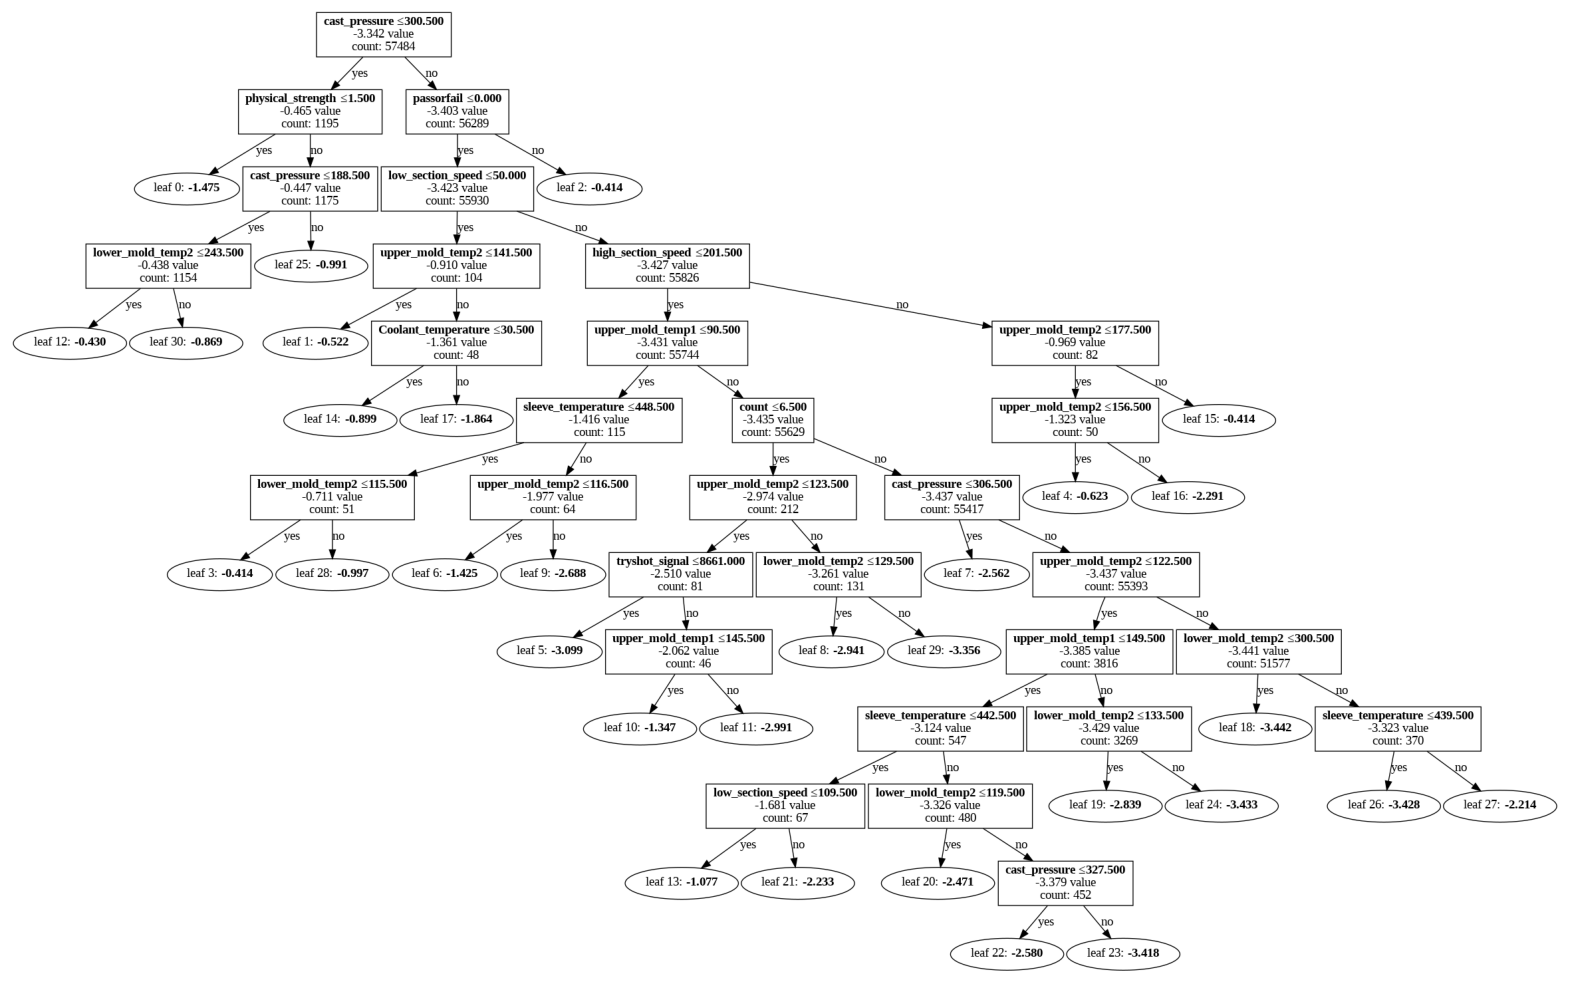

In [109]:
lgbm = LGBMClassifier(random_state=42)
tmp = pd.DataFrame(X[idx_list[lgbm_fold_f1[0][0]-1][0]], columns=df_done.columns[:-1])
lgbm.fit(tmp, y[idx_list[lgbm_fold_f1[0][0]-1][0]])
lightgbm.plot_tree(lgbm,dpi=100,orientation='vertical',figsize=(20,15), show_info=['internal_value', 'internal_count'])